In [1]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00


In [2]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-lavibas23',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [3]:
map = geemap.Map(basemap ='SATELLITE')
map



Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [22]:
roi = map.draw_last_feature.geometry()

roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          79.732932,
                          6.219743
                        ],
                        [
                          79.732932,
                          7.027298
                        ],
                        [
                          80.326021,
                          7.027298
                        ],
                        [
                          80.326021,
                          6.219743
                        ],
                        [
                          79.732932,
                          6.219743
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [23]:
daily_col = (
    ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_D1K_PM25")
    .filterDate('2017','2022')
)

daily_col

In [24]:
daily_ds = xr.open_dataset(
    daily_col,
    engine = 'ee',
    crs  = 'EPSG:4326',
    geometry = roi,
    scale = 0.001
)

daily_ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 1822, lon: 593, lat: 808)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2017-01-01 2017-01-02 ... 2021-12-31
  * lon      (lon) float64 5kB 79.73 79.73 79.74 79.74 ... 80.32 80.32 80.33
  * lat      (lat) float64 6kB 6.22 6.221 6.222 6.223 ... 7.025 7.026 7.027
Data variables:
    b1       (time, lon, lat) float32 3GB ...
Attributes:
    crs:      EPSG:4326

In [25]:
daily_ave = daily_ds.mean(dim = ['lat','lon']) * 0.1

daily_ave

<xarray.Dataset> Size: 22kB
Dimensions:  (time: 1822)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2017-01-01 2017-01-02 ... 2021-12-31
Data variables:
    b1       (time) float32 7kB 2.309 1.772 1.697 2.257 ... 2.753 2.959 2.556

<Axes: xlabel='time'>

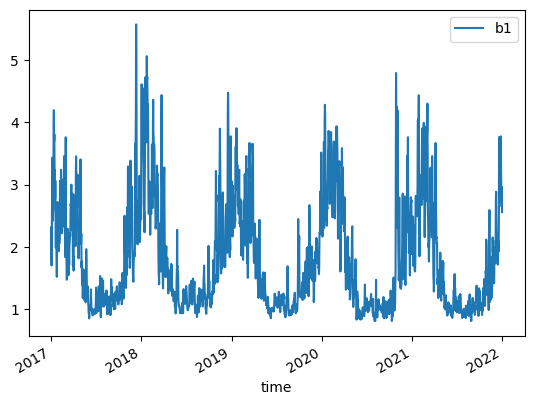

In [26]:
daily_df = daily_ave.to_dataframe()

daily_df.to_csv('daily_pm25.csv')

daily_df.plot()

In [27]:
monthly_col = (
    ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_M1K_PM25")
    .filterDate('2017', '2023')
)

In [28]:
monthly_ds = xr.open_dataset(
    monthly_col,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.001,
    geometry = roi
)

monthly_ds


<xarray.Dataset> Size: 138MB
Dimensions:  (time: 72, lon: 593, lat: 808)
Coordinates:
  * time     (time) datetime64[ns] 576B 2017-01-01 2017-02-01 ... 2022-12-01
  * lon      (lon) float64 5kB 79.73 79.73 79.74 79.74 ... 80.32 80.32 80.33
  * lat      (lat) float64 6kB 6.22 6.221 6.222 6.223 ... 7.025 7.026 7.027
Data variables:
    b1       (time, lon, lat) float32 138MB ...
Attributes:
    crs:      EPSG:4326

In [29]:
month_mean = monthly_ds.groupby('time.month').mean('time') * 0.1

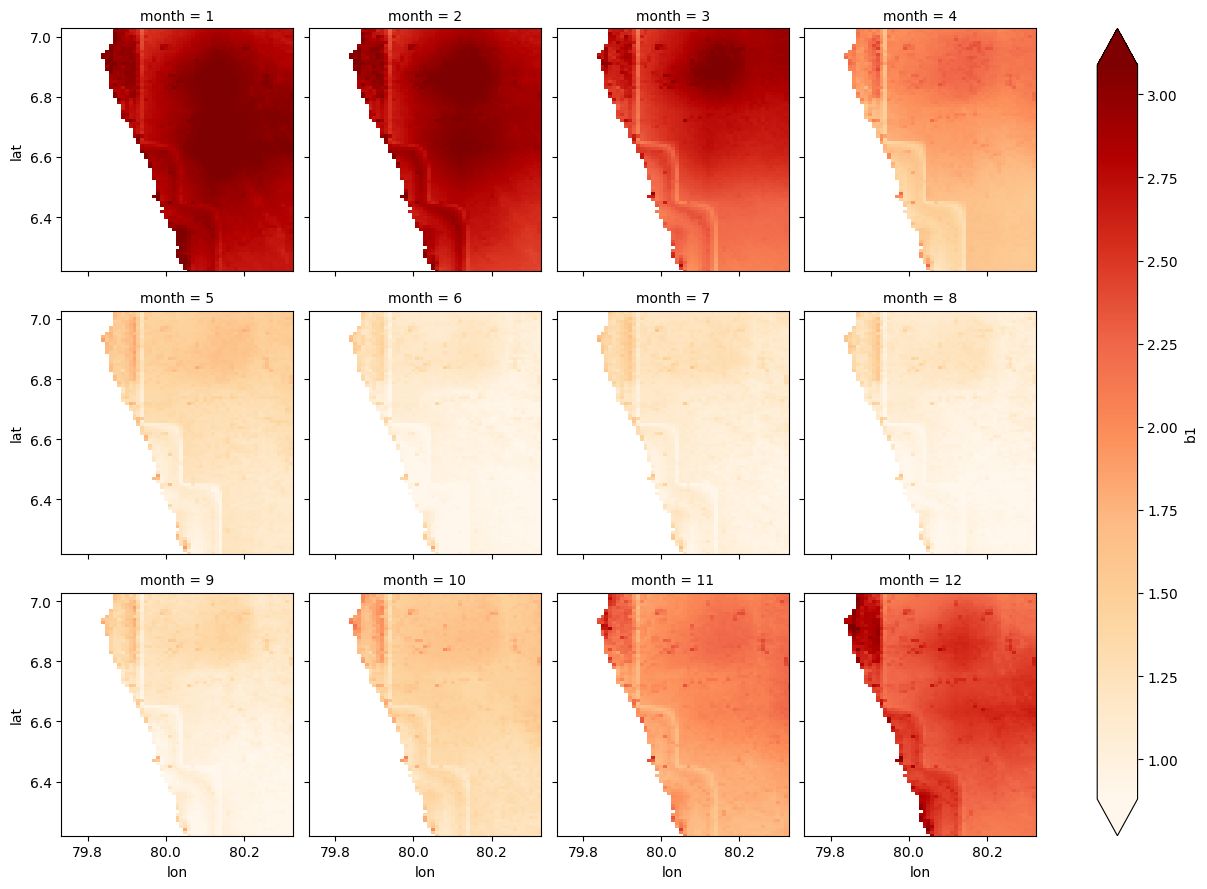

In [30]:
import matplotlib.pyplot as plt

month_mean.b1.plot(
    x = 'lon',
    y = 'lat',
    col = 'month',
    robust = True,
    col_wrap = 4,
    cmap = 'OrRd'
)

In [31]:
plt.savefig('monthly_pm25.png', dpi = 360, bbox_inches = 'tight')

<Figure size 640x480 with 0 Axes>

In [32]:
monthly_ave = monthly_ds.mean(dim = ['lat', 'lon']) * 0.1

monthly_ave

<xarray.Dataset> Size: 864B
Dimensions:  (time: 72)
Coordinates:
  * time     (time) datetime64[ns] 576B 2017-01-01 2017-02-01 ... 2022-12-01
Data variables:
    b1       (time) float32 288B 2.652 2.591 2.164 2.504 ... 1.545 2.233 2.375

<Axes: xlabel='time'>

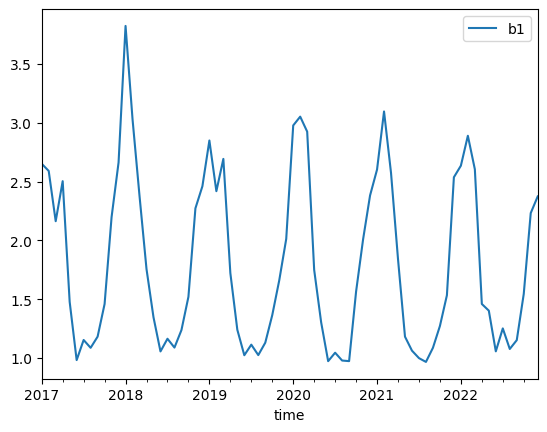

In [33]:
monthly_df = monthly_ave.to_dataframe()

monthly_df.plot()

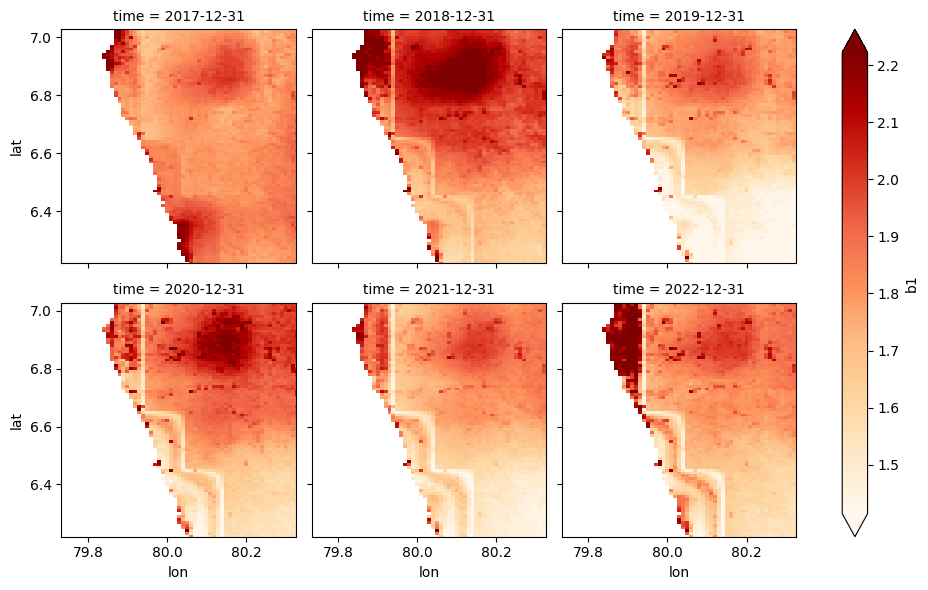

In [34]:
annual_ds = monthly_ds.resample(time = 'YE').mean('time') * 0.1

annual_ds.b1.plot(
    x = 'lon',
    y = 'lat',
    robust = True,
    col = 'time',
    col_wrap = 3,
    cmap = 'OrRd'
)